In [87]:
#UPDATED SQL SERVER PULLER ON SQLSERVER 02
import pyodbc
from tools import *
import json
'''server: wdtdevsql02
database: WDT_PROD
login: application
password: !v80VD8gX!vK'''

'server: wdtdevsql02\ndatabase: WDT_PROD\nlogin: application\npassword: !v80VD8gX!vK'

In [156]:
server = 'wdtdevsql01'
database = 'WDT_PROD'
username= 'application'
password= '!v80VD8gX!vK'
pyodbc_cnntr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password

In [157]:
ids = []
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
cursor.execute("SELECT ProcessDataID FROM Process INNER JOIN ProcessData ON Process.ProcessID = ProcessData.ProcessID WHERE Process.ProcessTypeID = 29 AND ProcessData.ProcessingRequired = 1")
for row in cursor.fetchall():
    ids.append(row.ProcessDataID)
cnxn.close()

In [158]:
file_data = {}
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
cursor.execute("SELECT ProcessID, ProcessDataID, ModelID, Model, RawData FROM bdc_tblfn_getEISDataToFitByProcessDataID(1302393)")
for row in cursor.fetchall():
    file_data.update({row.ProcessDataID:row.RawData})
cnxn.close()
file_data = json.loads(file_data[1302393])

In [159]:
freq = []
re = []
im = []
for i in file_data:
    freq.append(i['Frequency_Hz'])
    im.append(i['Minus_Z_Imaginary_Ohm'])
    re.append(i['Z_Real_Ohm'])

In [160]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func = 'modulus'):
        if circuit == 'R-RQ-RQ':
            re_fit = cir_RsRQRQ_fit(params, w).real
            im_fit = -cir_RsRQRQ_fit(params, w).imag
        elif circuit == 'R-RQ-Q':
            re_fit = cir_RsRQQ_fit(params, w).real
            im_fit = -cir_RsRQQ_fit(params, w).imag
        elif circuit == 'R-RQ-RQ2':
            re_fit = cir_RsRQRQ2_fit(params, w).real
            im_fit = -cir_RsRQRQ2_fit(params, w).imag
        elif circuit == 'R-RQ-RQ-Q':
            re_fit = cir_RsRQRQQ_fit(params, w).real
            im_fit = -cir_RsRQRQQ_fit(params, w).imag
        else:
            print('Circuit is not defined in leastsq_errorfunc()')

        error = ([(re-re_fit)**2, (im-im_fit)**2]) #sum of squares
        
        #Different Weighing options, see Lasia
        if weight_func == 'modulus':
            weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
        elif weight_func == 'proportional':
            weight = [1/(re_fit**2), 1/(im_fit**2)]
        elif weight_func == 'unity':
            unity_1s = []
            for k in range(len(re)):
                unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
            weight = [unity_1s, unity_1s]
        else:
            print('weight not defined in leastsq_errorfunc()')
        
        S = np.array(weight) * error #weighted sum of squares 
        return S

No handles with labels found to put in legend.


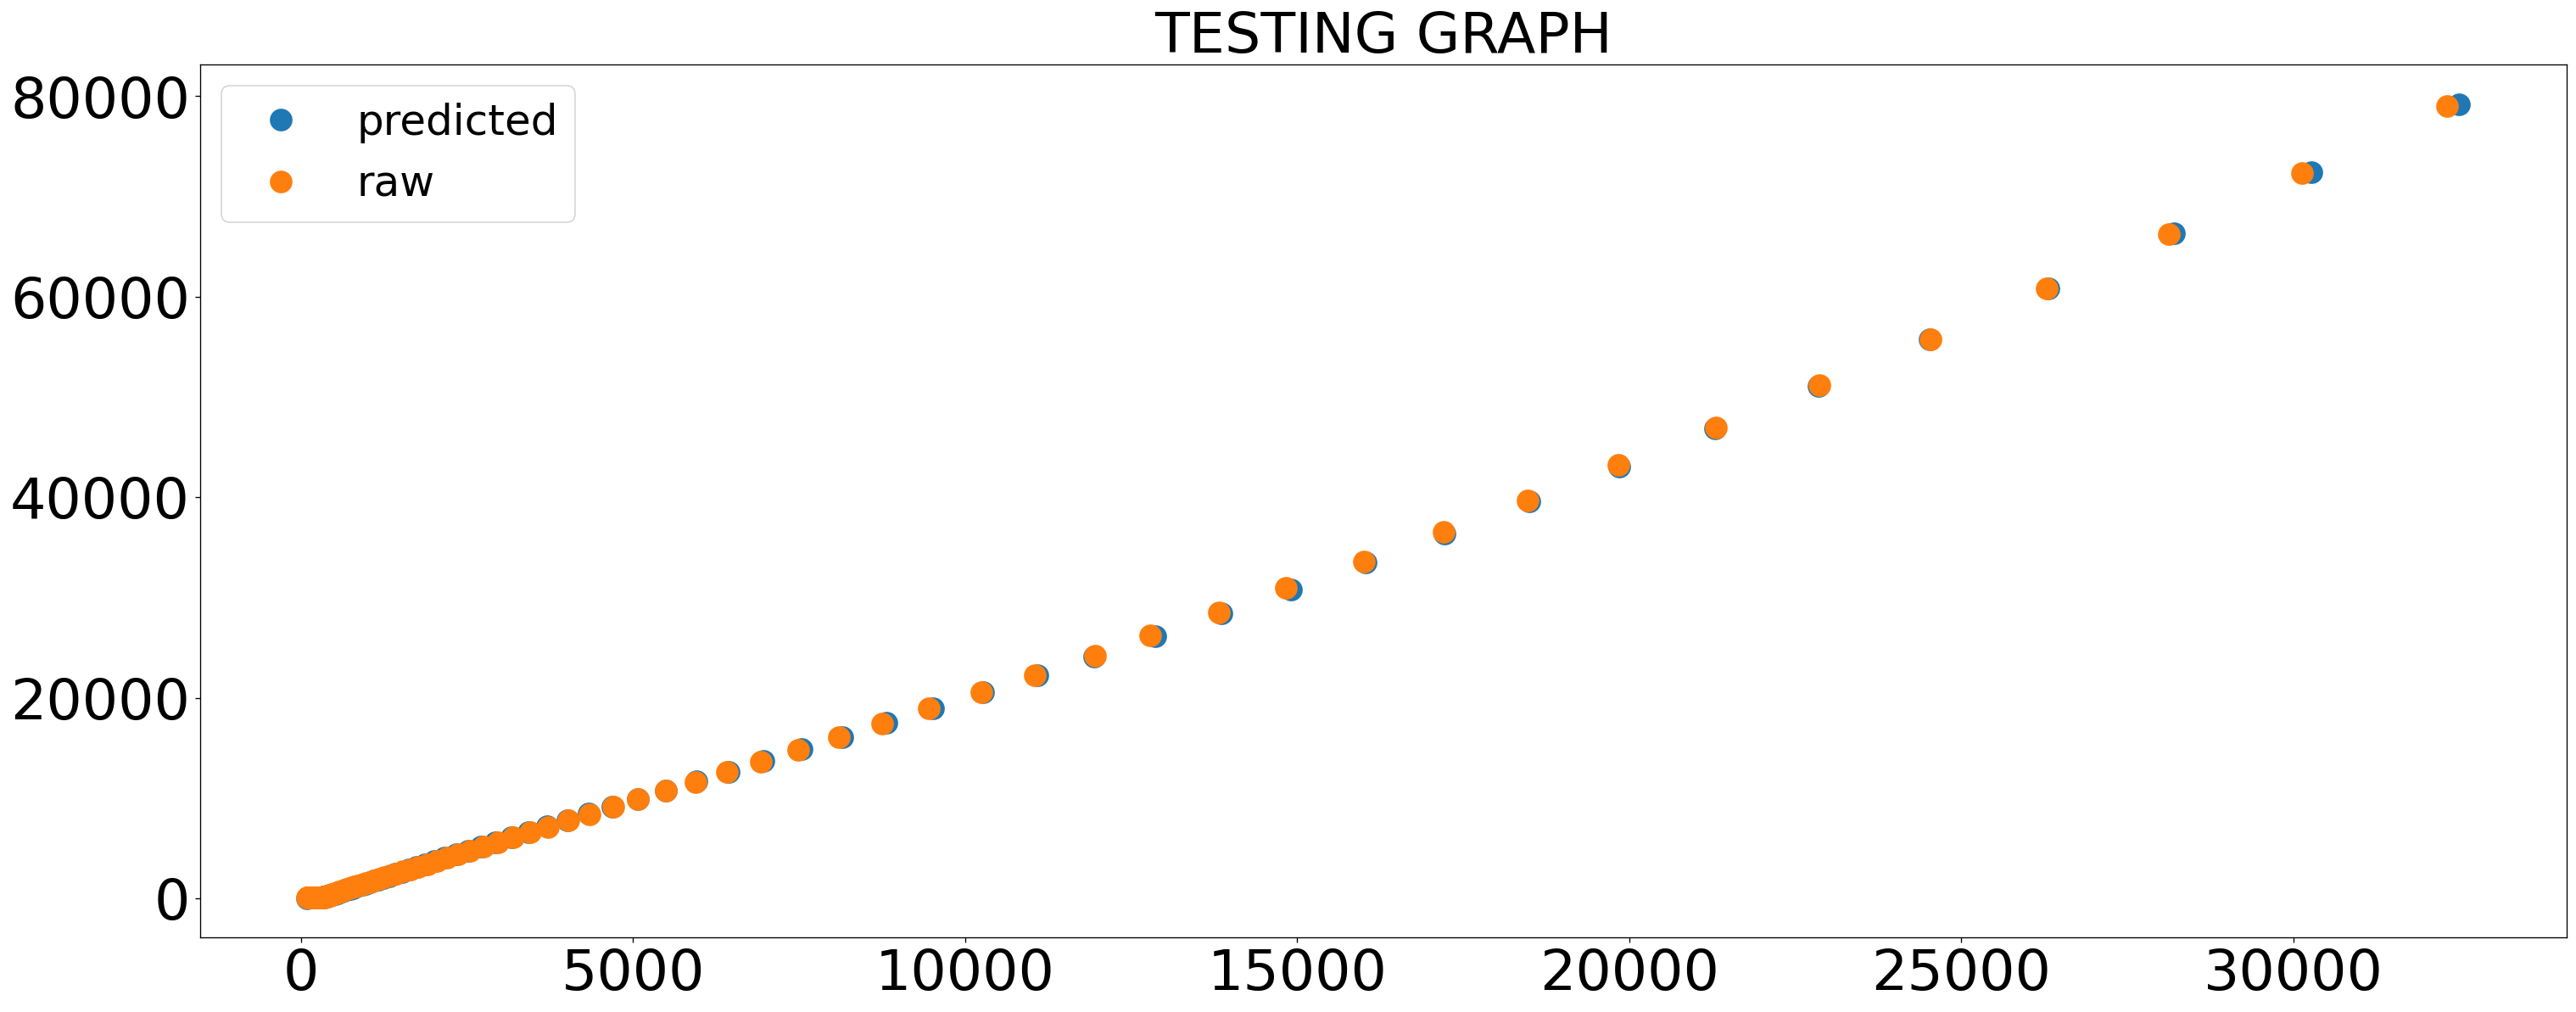

In [161]:
#Formatting the database results into pd series for minimizing module function
freq = pd.Series([np.float64(i) for i in freq])
re = pd.Series([np.float64(i) for i in re])
im = pd.Series([np.float64(i) for i in im])
init_guesses = []
param_list = []
#pre_coeffs = []
for i in range(20):
    #initial guesses still rely on the real values
    Rs_guess = min(re)
    R1_guess = max(re)//4
    n1_guess = random.uniform(0, 1)
    q1_guess = random.uniform(0, .001)
    R2_guess = 2*max(re)//4
    n2_guess = random.uniform(0, 1)
    q2_guess = random.uniform(0, .001)
    Q3_guess = random.uniform(0, .001)
    n3_guess = random.uniform(0, 1)
    params = Parameters()
    params.add('Rs', value=Rs_guess, min=Rs_guess*.001, max=Rs_guess*10)
    params.add('R1', value=R1_guess, min=R1_guess*.001, max=R1_guess*10)
    params.add('n1', value=n1_guess, min=0, max=1)
    params.add('Q1', value=q1_guess, min=0, max=.001)
    params.add('R2', value=R2_guess, min=R2_guess*.001, max=R2_guess*10)
    params.add('n2', value=n2_guess, min=.01, max=1)
    params.add('Q2', value=q2_guess, min=0, max=.001)
    params.add('Q', value=Q3_guess, min=0, max=.001)
    params.add('n', value=n3_guess, min=.01, max=1)
    param_list.append(params)
    circuit = 'R-RQ-RQ-Q'
    weight_func = 'modulus'
    nan_policy = 'raise'
    maxfev = 5000
    #MINIMIZE CANNOT TAKE IN LISTS
    #IT MUST BE PD SERIES
    #ALSO IT MUST BE CALLED SERIES.VALUES
    #NOT JUST SERIES
    fitted_data = minimize(leastsq_errorfunc, params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
    #pre_coeffs.append(fitted_data.params.valuesdict())
    #print("CHI-SQ ERROR: ", fitted_data.chisqr)
    init_guesses.append(fitted_data.chisqr)
    #print("PARAMS")
    #pp.pprint(fitted_data.params)
optimal_params = param_list[init_guesses.index(min(init_guesses))]
fitted_dict = optimal_params.valuesdict()
fitted_data=minimize(leastsq_errorfunc, optimal_params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
#PLOTTING
#Collecting the fitted data to prepare for plotting te points
fitted_points = cir_RsRQRQQ(w=freq.values, Rs=fitted_data.params.get('Rs').value, Q=fitted_data.params.get('Q').value, n=fitted_data.params.get('n').value, R1=fitted_data.params.get('R1').value, Q1=fitted_data.params.get('Q1').value, n1=fitted_data.params.get('n1').value, fs1='None', R2=fitted_data.params.get('R2').value, Q2=fitted_data.params.get('Q2').value, n2=fitted_data.params.get('n2').value, fs2='None')
fig = plt.figure(dpi=120, figsize = [30, 25], facecolor='w', edgecolor='w')
#fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
ax = fig.add_subplot(211)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)
### Figure specifics
ax.set_title("TESTING GRAPH", fontsize = 40)
ax.legend(loc='best', fontsize=30, frameon=False)
#ax.set_xlim(0,1000)
#ax.set_ylim(0,1000)
#Color initialization
colors = sns.color_palette("colorblind", n_colors=1)
colors_real = sns.color_palette("Blues", n_colors=2)
colors_imag = sns.color_palette("Oranges", n_colors=2)
ax.plot(fitted_points.real, -fitted_points.imag, '.', label = 'predicted', markersize = 30)
ax.plot(re, im, '.', label = 'raw', markersize = 30)
ax.legend(fontsize = 30)
plt.show()

In [162]:
fitted_dict
fitted_params = json.dumps(fitted_dict)
print(fitted_params)

{"Rs": 99.734795, "R1": 8078.0, "n1": 0.39552997891306374, "Q1": 2.455268504823527e-05, "R2": 16157.0, "n2": 0.5038121467068213, "Q2": 0.0008373542315409199, "Q": 0.0007932634004064978, "n": 0.5172099457353616}


In [163]:
#THE REPLACEMENT UPDATING COMMANDS
"UPDATE ProcessData SET ProcessingStartDate = DateTime.Now, IsAttempted = 1 WHERE ProcessDataID = {0}"

#REMOVE OLD DATA
"DELETE FROM ACImpedance_Data WHERE ProcessDataID = ProcessDataID = {0}"

#REMOVE OLD FIT PARAMETERS
"DELETE FROM ACImpedance_FitParameters WHERE ProcessDataID = ProcessDataID = {0}"

#SAVE NEW FIT PARAMS
"INSERT INTO ACImpedance_Data VALUES (ProcessDataID, new fitted results)"

#SAVE NEW DATA
"INSERT INTO ACImpedance_FitParameters VALUES (ProcessDataID, new fitted results)"

#CLEAR PROCESSING FLAG
"UPDATE ProcessData SET ProcessingRequired = 0, ProcessingEndDate = datetime.now WHERE ProcessDataID = {0} "

'UPDATE ProcessData SET ProcessingRequired = 0, ProcessingEndDate = datetime.now WHERE ProcessDataID = {0} '

In [171]:
final = []
for i in fitted_dict.keys():
    final.append("("+str(1302392)+", '"+ str(i)+"',"+str(fitted_dict[i])+")")
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
for i in final:
    cursor.execute("INSERT INTO ACImpedanceData_FitParameter(ProcessDataID, ParameterName,ParameterValue) VALUES "+i)
cursor.commit()
cnxn.close()

In [172]:
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()  
cursor.execute("SELECT * FROM ACImpedanceData_FitParameter WHERE ProcessDataID=1302392;")  
for i in cursor.fetchall():
    print(i)
cnxn.close()

(1302392, 'n', 0.5172099457353616)
(1302392, 'n1', 0.39552997891306374)
(1302392, 'n2', 0.5038121467068213)
(1302392, 'Q', 0.0007932634004064978)
(1302392, 'Q1', 2.455268504823527e-05)
(1302392, 'Q2', 0.0008373542315409199)
(1302392, 'R1', 8078.0)
(1302392, 'R2', 16157.0)
(1302392, 'Rs', 99.734795)


In [128]:
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
cursor.execute("INSERT INTO ACImpedance_FitParameters VALUES ("+str(1302392)+","+json.dumps(fitted_dict)+")")
cnxn.close()

ProgrammingError: ('42000', '[42000] [Microsoft][ODBC Driver 17 for SQL Server]Syntax error, permission violation, or other nonspecific error (0) (SQLExecDirectW)')